# Working with SEG-Y data

In this eight and final lab of the ErSE 210 - Seismology course, we will learn how to work with seismic data in SEG-Y format.

[SEG-Y](https://en.wikipedia.org/wiki/SEG-Y) is a file format developed by the Society of Exploration Geophysicists (SEG) for storing geophysical data. It is an open standard and is controlled by the SEG Technical Standards Committee. Up until now, this is the most used format for storing and transferring seismic data and therefore it is important to learn how to use it.

Luckily for us, Equinor has developed an open-source Python library called [segyio](https://github.com/equinor/segyio) which eases reading and writing SEG-Y files in a simple manner. 

The notebook is organized as follow:

- Download a SEG-Y file from the [Volve open-source dataset](https://data.equinor.com)
- Learn the fundamentals of segyio to work with SEG-Y files
- Read and display the geometry and data for a raw data in common-shot 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import segyio

from scipy.signal import butter, lfilter, filtfilt, freqz, medfilt, fftconvolve
from scipy.sparse import csr_matrix, vstack
from scipy.signal import filtfilt
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc

from segyshot import SegyShot

## Data retrieval

Let's start by downloading the files of interest:

1. SEG-Y file containing several common-shot gathers (CSGs) for a single cable of the Volve OBC dataset that was acquired by Statoil (now Equinor) in 2010.
2. Migration velocity model.

In [2]:
# TO BE RUN ONLY ONCE TO RETRIEVE THE DATA (IF YOU WANT THE ENTIRE DATA)
#!az storage blob download --account-name datavillagesa --container-name volve  --name Seismic/ST10010/Raw_data/ST10010+NAV_MERGE/ST10010_1150780_40203.sgy --file ../Data/ST10010_1150780_40203.sgy --sas-token "$YOURTOKEN"

In [3]:
# TO BE RUN ONLY ONCE TO RETRIEVE THE DATA (IF YOU WANT THE ENTIRE DATA)
#!az storage blob download --account-name datavillagesa --container-name volve  --name Seismic/ST10010/Velocities/ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy --file ../Data/ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy --sas-token "$YOURTOKEN"

where you will need to substitute ``$YOURTOKEN`` with your personal token. To get a token, simply register at https://data.equinor.com/authenticate and find the token in the red text in the Usage section. Ensure to copy everything from `?sv=` to `=rl` in place of ``$YOURTOKEN``.

For the lab, I will be providing you with a small portion of the original dataset that I have created using the `volvedataprep.py` script.

## Segyio intro

Once the data has been dowloaded we can start inspecting it. We will do that using native `segyio` commands to familiarize with it (you may find it useful in your assigments to also read other kind of data: post-stack volumes, velocity models, etc.).

If you have never seen a SEG-Y file, it is reccomended to spend some time reading its [specifications](https://en.wikipedia.org/wiki/SEG-Y). It's good to know sooner than later where to find useful information in the most popular format for storage of seismic data. 

In [4]:
inputfile = '../data/ST10010_1150780_40203_2dline1.sgy'
velfile = '../data/ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy'

f = segyio.open(inputfile, ignore_geometry=True)

In [5]:
# EBCDIC header containing textual information of the data
print(segyio.tools.wrap(f.text[0]))    

C 1 CLIENT: STATOIL           COMPANY: RESERVOIR EXPLORATION TECHNOLOGY
C 2 AREA: VOLVE NORWAY BLOCK 15/9                SURVEY: ST10010
C 3 SWATH:  11                             VESSELS:M/V VIKLAND, M/V SANCO
SPIRITC 4 RCV LINE: 1150780    RCVR RANGE: 1239-1717
C 5 DATA-SET: NAV MERGE   TRACES PER RECORD: 240 X 4   SEQ: 094-133
C 6 RECORDING FORMAT: IEEE SEG-Y           FORMAT THIS REEL: SEG-Y 3592
C 7 SAMPLE CODE: FLOATING PT               PROCESSED: 03/11/2010
C 8 ACQ. GEOM: 8 ROLL 8  INLINE SWATH      LINE PREFIX: ST10010
C 9 INSTRUMENT: VECTORSEIS OCEAN BOTTOM    RECORDING SYSTEM DELAY: 0 MS
C10 RECORDING FILTER: 1.5/6-187/260MIN PHS DESCRIPTION: HZ/DB PER OCTAVE
C11 NO OF RECEIVER LINES/SWATH: 8          RECEIVER LINE SEPARATION: 400/200M
C12 ACTIVE CABLE LENGTH: 5975M             RCVRS / RCV LINE 240 X 4
C13 NO OF SOURCES:  2                      SOURCE SEPARATION: 50M
C14 RECEIVER INTERVAL: 25M                 SHOT INTERVAL: 25M, FLIP/FLOP
C15 DATUM: ED50, 31N  SPHEROID: INT. 

In [6]:
# Binary header
print(f.bin)
print('JobID from binary header: ', f.bin[segyio.BinField.JobID])

{JobID: 10010, LineNumber: 0, ReelNumber: 0, Traces: 960, AuxTraces: 0, Interval: 2000, IntervalOriginal: 2000, Samples: 2000, SamplesOriginal: 5000, Format: 5, EnsembleFold: 0, SortingCode: 1, VerticalSum: 1, SweepFrequencyStart: 0, SweepFrequencyEnd: 0, SweepLength: 0, Sweep: 0, SweepChannel: 0, SweepTaperStart: 0, SweepTaperEnd: 0, Taper: 0, CorrelatedTraces: 0, BinaryGainRecovery: 0, AmplitudeRecovery: 1, MeasurementSystem: 1, ImpulseSignalPolarity: 1, VibratoryPolarity: 0, ExtAuxTraces: 0, ExtSamples: 0, ExtSamplesOriginal: 0, ExtEnsembleFold: 0, SEGYRevision: 0, SEGYRevisionMinor: 0, TraceFlag: 0, ExtendedHeaders: 0}
JobID from binary header:  10010


In [7]:
# Trace header
print('First trace header', f.header[0])
print('GroupX from first trace header', f.header[0][segyio.TraceField.GroupX])

First trace header {TRACE_SEQUENCE_LINE: 4761601, TRACE_SEQUENCE_FILE: 192001, FieldRecord: 1618, TraceNumber: 1, EnergySourcePoint: 1618, CDP: 10395429, CDP_TRACE: 0, TraceIdentificationCode: 1, NSummedTraces: 0, NStackedTraces: 0, DataUse: 1, offset: 4740, ReceiverGroupElevation: -1010, SourceSurfaceElevation: 1, SourceDepth: 63, ReceiverDatumElevation: 0, SourceDatumElevation: 0, SourceWaterDepth: 881, GroupWaterDepth: 1010, ElevationScalar: -10, SourceGroupScalar: -10, SourceX: 4357826, SourceY: 64765477, GroupX: 4311640, GroupY: 64776128, CoordinateUnits: 1, WeatheringVelocity: 0, SubWeatheringVelocity: 0, SourceUpholeTime: 0, GroupUpholeTime: 0, SourceStaticCorrection: 0, GroupStaticCorrection: 0, TotalStaticApplied: 0, LagTimeA: 0, LagTimeB: 0, DelayRecordingTime: 0, MuteTimeStart: 0, MuteTimeEND: 0, TRACE_SAMPLE_COUNT: 5000, TRACE_SAMPLE_INTERVAL: 2000, GainType: 1, InstrumentGainConstant: 6, InstrumentInitialGain: 0, Correlated: 0, SweepFrequencyStart: 0, SweepFrequencyEnd: 0,

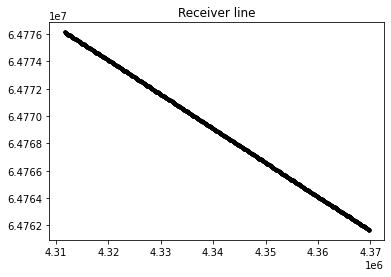

In [8]:
# Single header for whole file
gx, gy = f.attributes(segyio.TraceField.GroupX)[:], f.attributes(segyio.TraceField.GroupY)[:]

plt.figure()
plt.scatter(gx, gy, c='k', s=5)
plt.title('Receiver line');

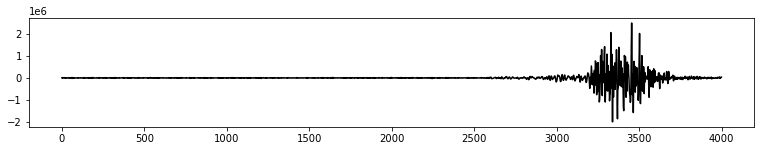

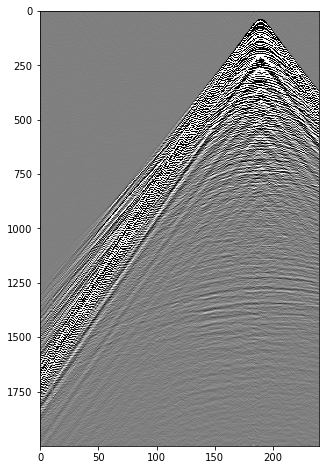

In [9]:
# Trace
tr = f.trace[0]
t = f.samples
plt.figure(figsize=(13, 2))
plt.plot(t, tr, 'k')
plt.axis('tight');

# Pressure shot gather (note that for each receiver the data is organized as follows: P,VZ,VX,VY. 
# So we take every 4th trace)
d = segyio.collect(f.trace[:240*4])
plt.figure(figsize=(5, 8))
plt.imshow(d[::4].T, cmap='gray', vmin=-1e5, vmax=1e5)
plt.axis('tight');

## Volve data inspection

Now that we have learned the basic commands of `segyio`, we are ready to work with our Volve dataset. To further simplify your life, a set of routines are also provided to easily read shot gathers and their geometry. Moreover we will use a velocity model to rotate the geometry of our acquisition to an ideal coordinate system.

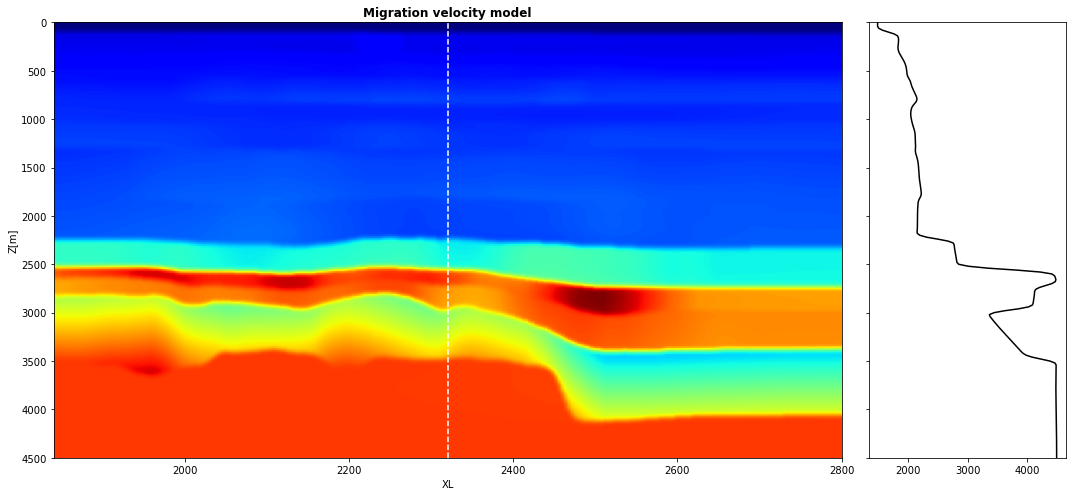

In [10]:
# Velocity file
fv = segyio.open(velfile)

# Depth axes
z = fv.samples
il, xl = fv.ilines, fv.xlines

# Velocity model 
vmod = segyio.cube(velfile)

fig, axs = plt.subplots(1, 2, figsize=(15, 7), sharey=True, gridspec_kw={'width_ratios': [4, 1]})
axs[0].imshow(vmod[50].T, extent=(xl[0], xl[-1], z[-1], z[0]), cmap='jet')
axs[0].axvline(xl[120], color='w', linestyle='--')
axs[0].set_title('Migration velocity model', fontweight='bold')
axs[0].set_xlabel('XL')
axs[0].set_ylabel('Z[m]')
axs[0].axis('tight')
axs[1].plot(vmod[50, 120], z, 'k')
plt.tight_layout();

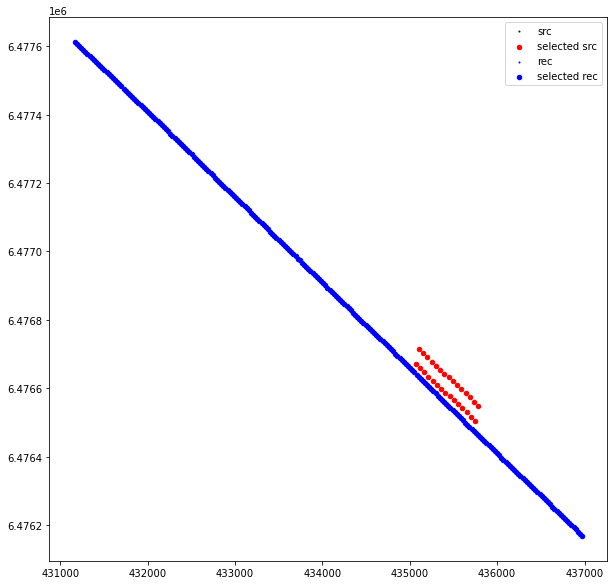

In [11]:
# Shot gather
sg = SegyShot(inputfile, components=['P', 'VZ', 'VX', 'VY'])
sg.interpret()
sg.showgeometry()

Let's now rotate the geometry to an ideal coordinate system

Local regular axis:
 ox=0.000000, dx=49.793406 nx=241
 oy=-0.000000, dy=49.540976 ny=109


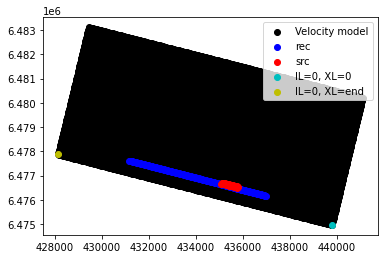

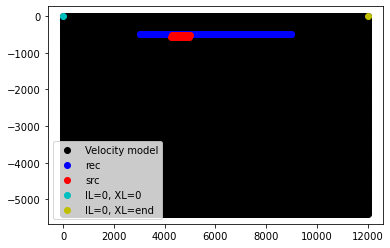

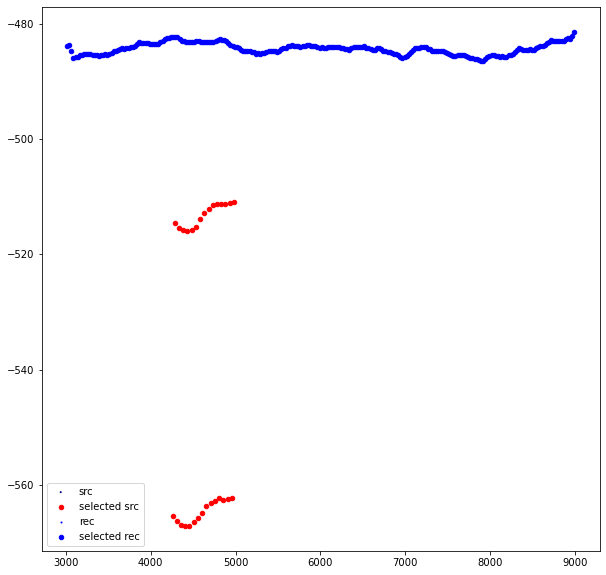

In [12]:
sg.rotategeometry(velfile=velfile, plotflag=1)
sg.showgeometry(local=True)

We can also select a subset of sources (or receivers)

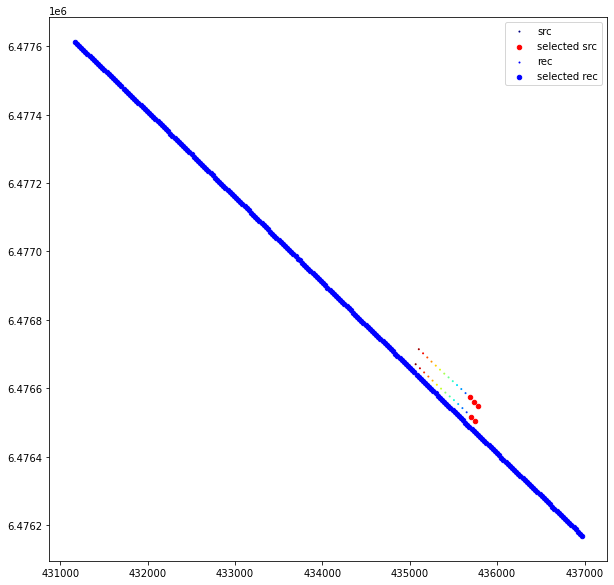

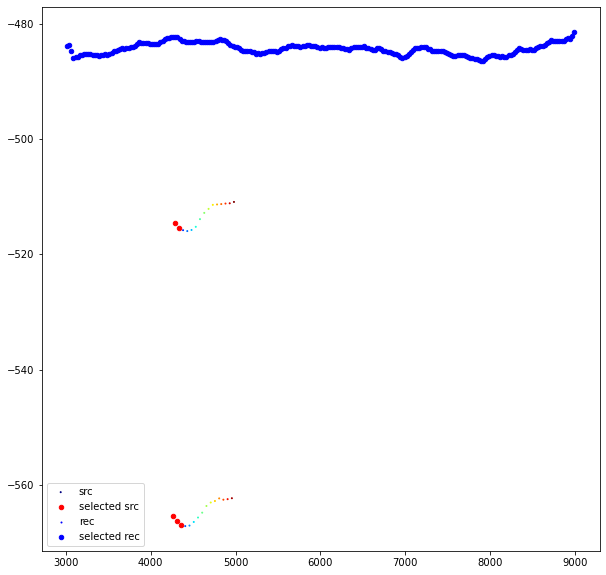

In [13]:
sg.selectsrcs(0, 5, plotflag=False)
sg.showgeometry()
sg.showgeometry(local=True)

Finally let's take a single shot and show the data for the 4 components. We can also use the header information to compute the traveltime of the direct arrival to show on top of the data

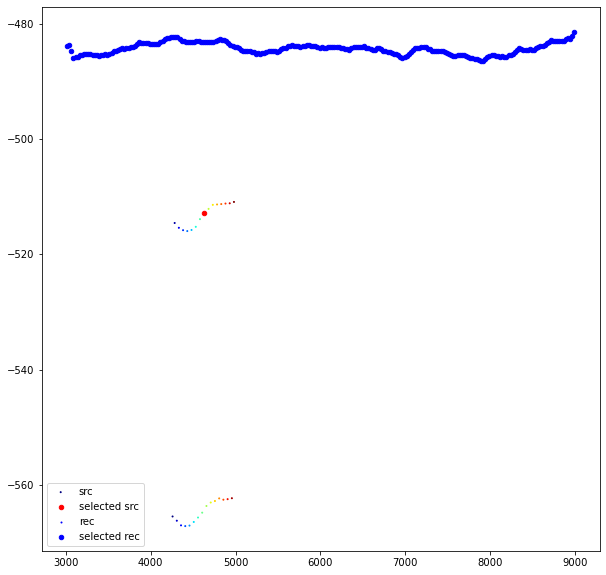

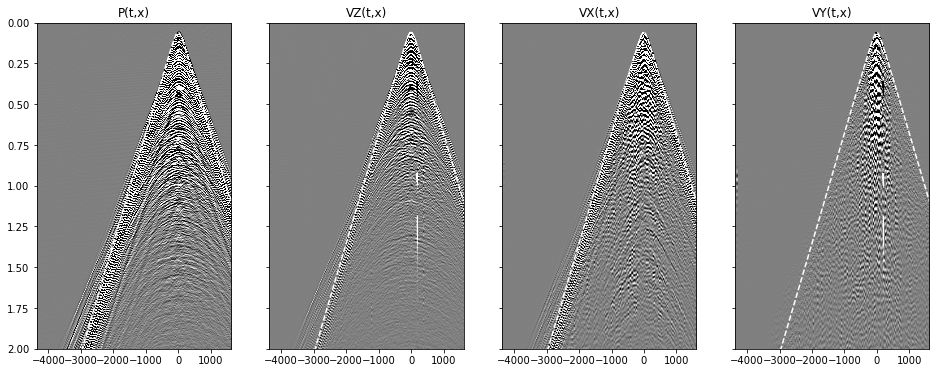

In [14]:
# Single shot
vel_dir = 1480.
ishotc = 15

sg.selectsrcs(ishotc, ishotc+1, plotflag=False)
sg.showgeometry(local=True)
shot = sg.get_shotgather(ishotc)

# Compute direct arrival
drec = np.mean(np.abs(np.diff(sg.recx_local)))
offset = np.sqrt((sg.srcx[ishotc] - sg.recx) ** 2 + (sg.srcy[ishotc] - sg.recy) ** 2)
distance = np.sqrt((sg.srcz[ishotc] - sg.recz) ** 2 + \
                   (sg.srcx[ishotc] - sg.recx) ** 2 + \
                   (sg.srcy[ishotc] - sg.recy) ** 2)
tdir = distance / vel_dir
offsetreg = np.linspace(-offset[0], offset[-1], sg.nrec)

# Display
vmax = 2e5
cmap = 'gray'
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 6))
axs[0].imshow(shot['P'].T, cmap=cmap, vmin=-vmax, vmax=vmax,
              extent = (offsetreg[0], offsetreg[-1], sg.t[-1], sg.t[0]))
axs[0].plot(offsetreg, tdir, '--w')
axs[0].set_title('P(t,x)')
axs[0].axis('tight')
axs[1].imshow(shot['VZ'].T, cmap=cmap, vmin=-vmax/10, vmax=vmax/10,
              extent = (offsetreg[0], offsetreg[-1], sg.t[-1], sg.t[0]))
axs[1].plot(offsetreg, tdir, '--w')
axs[1].set_title('VZ(t,x)')
axs[1].axis('tight')
axs[2].imshow(shot['VX'].T, cmap=cmap, vmin=-vmax/10, vmax=vmax/10,
              extent = (offsetreg[0], offsetreg[-1], sg.t[-1], sg.t[0]))
axs[2].plot(offsetreg, tdir, '--w')
axs[2].set_title('VX(t,x)')
axs[2].axis('tight')
axs[3].imshow(shot['VY'].T, cmap=cmap, vmin=-vmax/10, vmax=vmax/10,
              extent = (offsetreg[0], offsetreg[-1], sg.t[-1], sg.t[0]))
axs[3].plot(offsetreg, tdir, '--w')
axs[3].set_title('VY(t,x)')
axs[3].axis('tight')
axs[3].set_ylim(2, 0);

Finally we shall remember that when we process data in a 2D sense, we should correct for the 3D geometrical spreading. This can be easily done by multiplying the data with a gain equal to $\sqrt{t}$

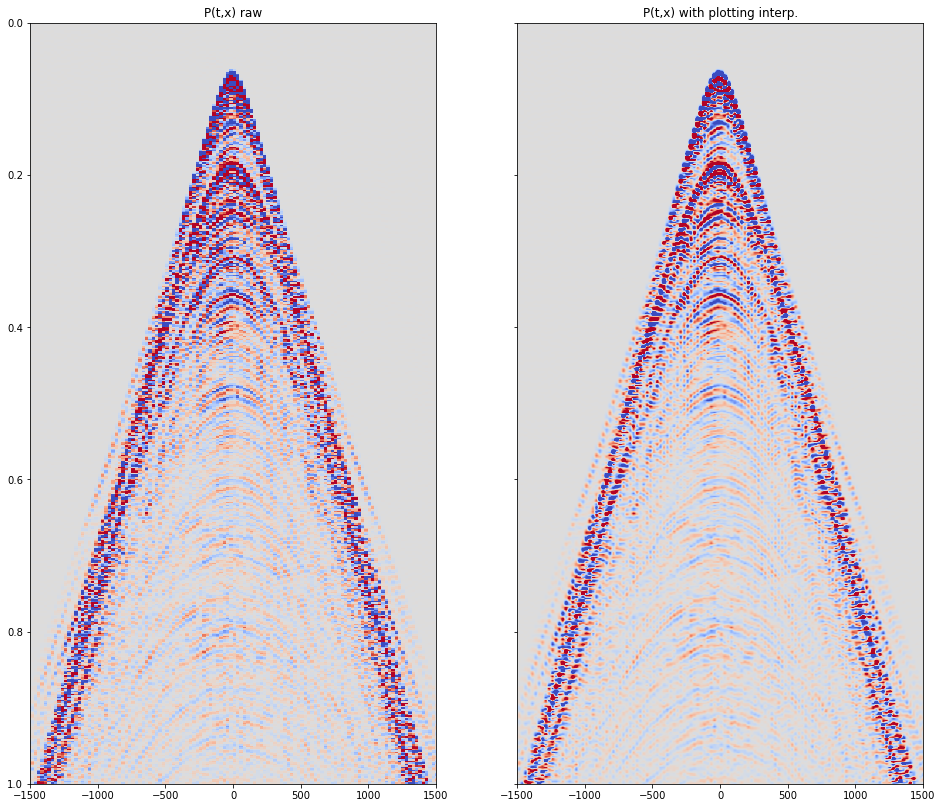

In [15]:
tgain = np.sqrt(sg.t)

# Display
vmax = 3e6
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16, 14))
axs[0].imshow(shot['P'].T * tgain[:, np.newaxis], cmap='coolwarm', vmin=-vmax, vmax=vmax,
          extent=(offsetreg[0], offsetreg[-1], sg.t[-1], sg.t[0]), interpolation='none')
axs[0].set_title('P(t,x) raw')
axs[0].axis('tight')
axs[1].imshow(shot['P'].T * tgain[:, np.newaxis], cmap='coolwarm', vmin=-vmax, vmax=vmax,
          extent=(offsetreg[0], offsetreg[-1], sg.t[-1], sg.t[0]), interpolation='antialiased')
axs[1].set_title('P(t,x) with plotting interp.')
axs[1].axis('tight')
axs[1].set_xlim(-1500, 1500)
axs[1].set_ylim(1, 0);

We can see that the data (especially the direct arrival and refractions) is pretty aliased. Let's look at the frequency and frequency-wavenumber content of the data

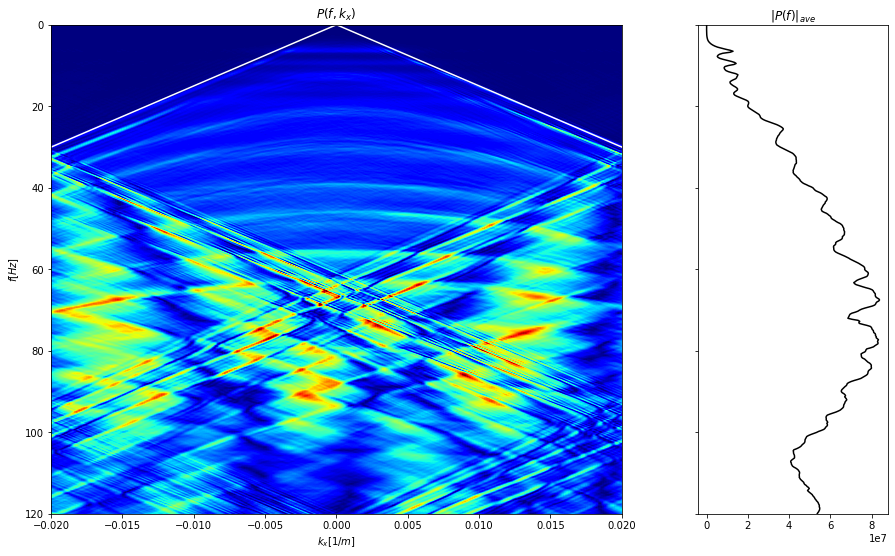

In [16]:
vsea = 1500
nffts = (sg.nrec, sg.nt)
freq = np.fft.fftfreq(nffts[1], sg.dt)
kx = np.fft.fftfreq(nffts[0], np.mean(np.diff(sg.recx)))

Pf = np.fft.fft(shot['P'], n=nffts[1], axis=-1)
Pfk = np.fft.fft2(shot['P'], s=nffts)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(15, 9), gridspec_kw={'width_ratios': [3, 1]})
axs[0].imshow(np.fft.fftshift(np.abs(Pfk[:, :nffts[1]//2-1]), axes=0).T, cmap='jet', interpolation='sinc',
              extent = (-kx[nffts[0]//2-1], kx[nffts[0]//2-1], freq[nffts[1]//2-1], freq[0]))
axs[0].plot(np.abs(freq[0:nffts[1]//2])/vsea, freq[0:nffts[1]//2], 'w')
axs[0].plot(-np.abs(freq[0:nffts[1]//2])/vsea, freq[0:nffts[1]//2], 'w')
axs[0].set_title(r'$P(f,k_x)$')
axs[0].set_ylabel(r'$f [Hz]$')
axs[0].set_xlabel(r'$k_x [1/m]$')
axs[0].axis('tight')
axs[0].set_xlim(-0.02, 0.02)
axs[1].plot(np.mean(np.abs(Pf), axis=0)[:nffts[1]//2], freq[:nffts[1]//2], 'k')
axs[1].set_title(r'$|P(f)|_{ave}$');
axs[1].set_ylim(120, 0);

We can try to remove the aliasing effects the 

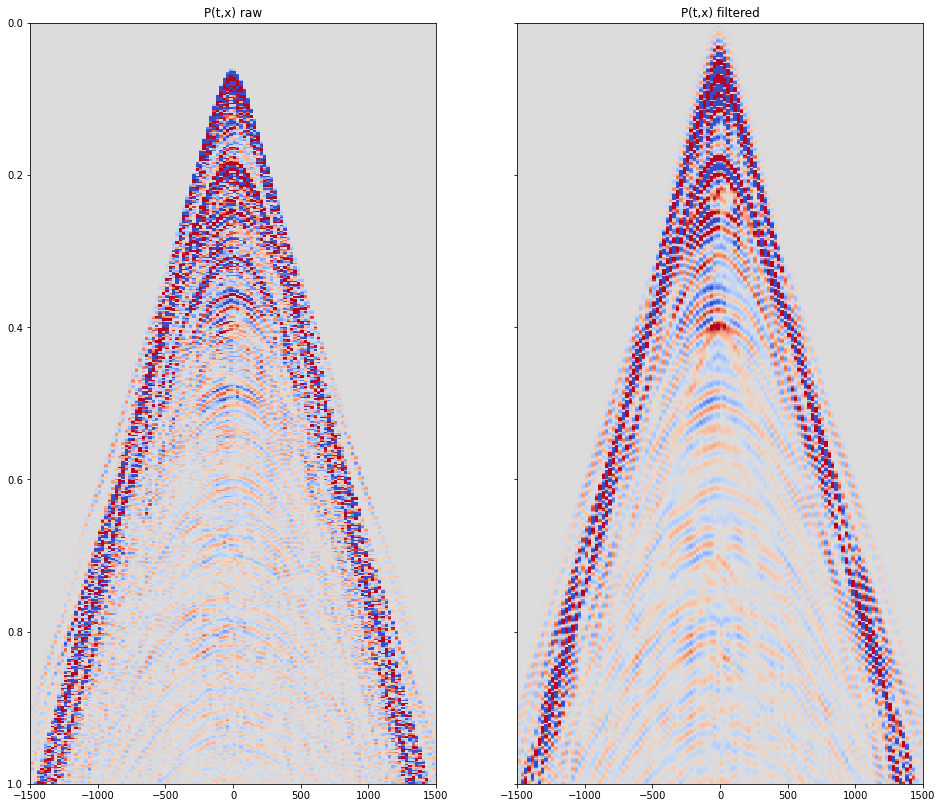

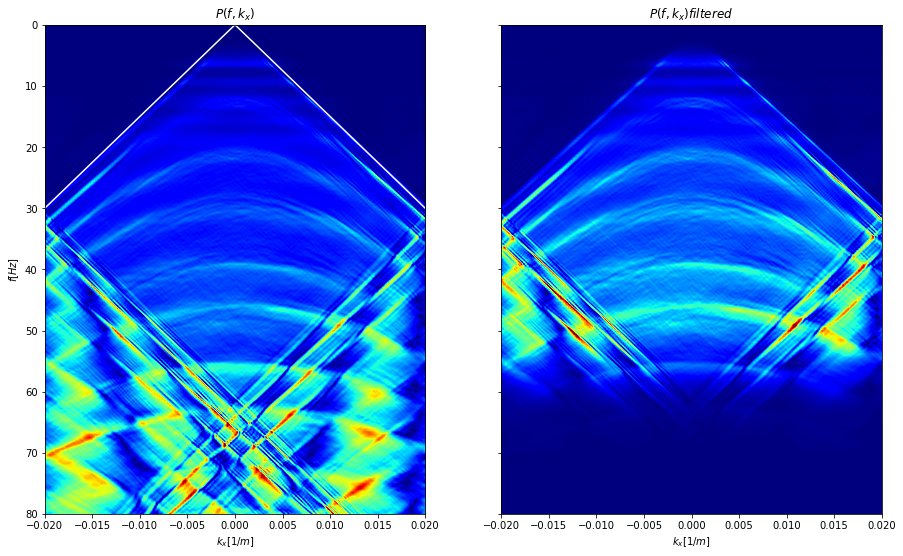

In [17]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

pfilt = butter_lowpass_filter(shot['P'], 55., 1/sg.dt, 11)
Pfiltfk = np.fft.fft2(pfilt, s=nffts)

# Display
vmax = 3e6
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16, 14))
axs[0].imshow(shot['P'].T * tgain[:, np.newaxis], cmap='coolwarm', vmin=-vmax, vmax=vmax,
          extent=(offsetreg[0], offsetreg[-1], sg.t[-1], sg.t[0]), interpolation='none')
axs[0].set_title('P(t,x) raw')
axs[0].axis('tight')
axs[1].imshow(pfilt.T * tgain[:, np.newaxis], cmap='coolwarm', vmin=-vmax/2, vmax=vmax/2,
          extent=(offsetreg[0], offsetreg[-1], sg.t[-1], sg.t[0]), interpolation='none')
axs[1].set_title('P(t,x) filtered')
axs[1].axis('tight')
axs[1].set_xlim(-1500, 1500)
axs[1].set_ylim(1, 0);

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(15, 9))
axs[0].imshow(np.fft.fftshift(np.abs(Pfk[:, :nffts[1]//2-1]), axes=0).T, cmap='jet', interpolation='sinc',
              extent = (-kx[nffts[0]//2-1], kx[nffts[0]//2-1], freq[nffts[1]//2-1], freq[0]))
axs[0].plot(np.abs(freq[0:nffts[1]//2])/vsea, freq[0:nffts[1]//2], 'w')
axs[0].plot(-np.abs(freq[0:nffts[1]//2])/vsea, freq[0:nffts[1]//2], 'w')
axs[0].set_title(r'$P(f,k_x)$')
axs[0].set_ylabel(r'$f [Hz]$')
axs[0].set_xlabel(r'$k_x [1/m]$')
axs[0].axis('tight')
axs[0].set_xlim(-0.02, 0.02)
axs[1].imshow(np.fft.fftshift(np.abs(Pfiltfk[:, :nffts[1]//2-1]), axes=0).T, cmap='jet', interpolation='sinc',
              extent = (-kx[nffts[0]//2-1], kx[nffts[0]//2-1], freq[nffts[1]//2-1], freq[0]))
axs[1].set_title(r'$P(f,k_x) filtered$')
axs[1].set_xlabel(r'$k_x [1/m]$')
axs[1].axis('tight')
axs[1].set_xlim(-0.02, 0.02)
axs[1].set_ylim(80, 0);